---
layout: post  
---

In [1]:
import Pkg
pkgs = [
    "Eisenia",
    "Random",
    "Revise",
    "BioSequences",
    "Test",
    "LightGraphs",
    "Primes",
    "Statistics",
    "Plots"
]

for pkg in pkgs
    try
        Pkg.add(pkg)
    catch
        # tried to install an unregistered local package
    end
    eval(Meta.parse("import $pkg"))
end

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %4.3 %============>                            ]  28.6 %42.7 % [======================>                  ]  52.8 %66.9 %=================================>       ]  81.2 %]  95.4 %

  Resolving package versions...
┌ Info: Precompiling Eisenia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
└ @ Base loading.jl:1278
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Res

In [2]:
function my_plot(graph::Eisenia.KmerGraph)
    graph_hash = hash(sort(graph.graph.fadjlist), hash(graph.graph.ne))
    filename = "/assets/images/$(graph_hash).svg"
    p = Eisenia.plot_graph(graph)
    Plots.savefig(p, dirname(pwd()) * filename)
    display(p)
    display("text/markdown", "![]($filename)")
end

my_plot (generic function with 1 method)

In [5]:
function assess_observations(graph::Eisenia.KmerGraph{KMER_TYPE}, observations, error_rate) where {KMER_TYPE}
    k = last(KMER_TYPE.parameters)
    total_edits_accepted = 0
    total_bases_evaluated = 0
    reads_processed = 0
    maximum_likelihood_observations = Vector{BioSequences.LongDNASeq}(undef, length(observations))
    for (observation_index, observation) in enumerate(observations)
        if length(observation) >= k
            optimal_path, edit_distance, relative_likelihood = Eisenia.viterbi_maximum_likelihood_path(graph, observation, error_rate)
            maximum_likelihood_observation = Eisenia.oriented_path_to_sequence(optimal_path, graph.kmers)
            maximum_likelihood_observations[observation_index] = maximum_likelihood_observation
            reads_processed += 1
            total_bases_evaluated += length(observation)
            total_edits_accepted += edit_distance
        else
            maximum_likelihood_observations[observation_index] = observation
        end
    end
    inferred_error_rate = round(total_edits_accepted / total_bases_evaluated, digits = 3)
    display("reads_processed = $(reads_processed)")
    display("total_edits_accepted = $(total_edits_accepted)")
    display("inferred_error_rate = $(inferred_error_rate)")
    if total_edits_accepted == 0
        has_converged = true
    else
        has_converged = false
    end
    return maximum_likelihood_observations, has_converged
end

assess_observations (generic function with 1 method)

In [12]:
function iterate_until_convergence(ks, observations, error_rate)
    for k in ks
        graph = Eisenia.KmerGraph(BioSequences.DNAMer{k}, observations)
        display("k = $k")
        my_plot(graph)
        observations, has_converged = assess_observations(graph, observations, error_rate)
    end
    graph = Eisenia.KmerGraph(BioSequences.DNAMer{last(ks)}, observations)
    display("final graph")
    my_plot(graph)
    return graph, observations
end

iterate_until_convergence (generic function with 1 method)

In [17]:
function clip_low_coverage_tips(graph, observations)
    connected_components = LightGraphs.connected_components(graph.graph)
    vertices_to_keep = Int[]
    for connected_component in connected_components
        
        component_coverage = graph.counts[connected_component]
        median = Statistics.median(component_coverage)
        standard_deviation = Statistics.std(component_coverage)
        
        tips = filter(vertex -> LightGraphs.degree(graph.graph, vertex) == 1, connected_component)
        
        for vertex in connected_component
            keep_me = true
            if LightGraphs.degree(graph.graph, vertex) == 1
                this_coverage = graph.counts[vertex]
                is_low_coverage = (graph.counts[vertex] == 1) || 
                                    (median-this_coverage) > (3*standard_deviation)
                if is_low_coverage
                    skip_me = false
                end
            end
            if keep_me
                push!(vertices_to_keep, vertex)
            end
        end
    end
    
#     KmerType = first(typeof(graph).parameters)
    pruned_graph = Eisenia.KmerGraph(KmerType, observations, graph.kmers[vertices_to_keep], graph.counts[vertices_to_keep])
    
    return pruned_graph
end

clip_low_coverage_tips (generic function with 1 method)

In [18]:
function take_a_walk(graph, connected_component)
    max_count = maximum(graph.counts[connected_component])
    max_count_indices = findall(count -> count == max_count, graph.counts[connected_component])
    initial_node_index = rand(max_count_indices)
    initial_node = connected_component[initial_node_index]
    outgoing_edge_probabilities, incoming_edge_probabilities = Eisenia.determine_edge_probabilities(graph)
    forward_walk = take_a_walk(graph, [Eisenia.OrientedKmer(index = initial_node, orientation = true)], outgoing_edge_probabilities, incoming_edge_probabilities)
    reverse_walk = take_a_walk(graph, [Eisenia.OrientedKmer(index = initial_node, orientation = false)], outgoing_edge_probabilities, incoming_edge_probabilities)
    reversed_reverse_walk = reverse!(
        [
            Eisenia.OrientedKmer(index = oriented_kmer.index, orientation = oriented_kmer.orientation)
            for oriented_kmer in reverse_walk[2:end]
        ]
        )
    full_path = [reversed_reverse_walk..., forward_walk]
    @show full_path
end

function take_a_walk(graph, path::Vector{Eisenia.OrientedKmer}, outgoing_edge_probabilities, incoming_edge_probabilities)
    done = false
    while !done
        maximum_path_likelihood = 0.0
        maximum_likelihood_path = Vector{Eisenia.OrientedKmer}()
        for neighbor in LightGraphs.neighbors(graph.graph, last(path).index)
            this_path = [last(path).index, neighbor]
            this_oriented_path, this_path_likelihood = 
                Eisenia.assess_path(this_path,
                    graph.kmers,
                    graph.counts,
                    last(path).orientation,
                    outgoing_edge_probabilities,
                    incoming_edge_probabilities)
            if this_path_likelihood > maximum_path_likelihood
                maximum_path_likelihood = this_path_likelihood
                maximum_likelihood_path = this_oriented_path
            end
        end
        if isempty(maximum_likelihood_path) && (maximum_path_likelihood == 0.0)
            done = true
        else
            append!(path, maximum_likelihood_path[2:end])
        end
    end
    return path
end

take_a_walk (generic function with 2 methods)

In [9]:
n_sequences = 1
seqlen = 10
sequences = [BioSequences.randdnaseq(Random.seed!(i), seqlen) for i in 1:n_sequences]

1-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 TCGTCCCAGG

In [10]:
n_observations = 100
error_rate = 0.05

Random.seed!(1)
observations = [
    Eisenia.observe(rand(sequences), error_rate = error_rate) 
        for i in 1:n_observations
]

100-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 CCTGGGACGA
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGGATCGA
 CCTGGGACGA
 TCGTCCCAGG
 TCGTCCAGG
 TGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 CCTGGGACCA
 TCGTCCCAGG
 CCTGGGACGA
 ⋮
 TCGTCCCAGCG
 TCGTCCCATG
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGCGACGA
 TCGTCCCAGG
 TCGTCCCAGG
 TCACGTCCCGAGG
 CCTGGGACGA
 TCGCTCCCAGG

"k = 3"

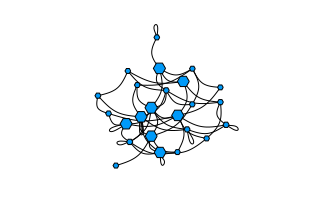

![](/assets/images/11516063661208544668.svg)

"reads_processed = 100"

"total_edits_accepted = 37"

"inferred_error_rate = 0.037"

"k = 5"

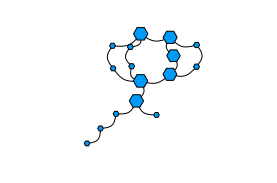

![](/assets/images/9366657123667438041.svg)

"reads_processed = 100"

"total_edits_accepted = 17"

"inferred_error_rate = 0.017"

"k = 7"

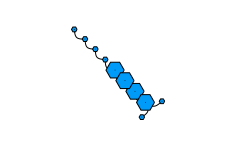

![](/assets/images/7625239065058145842.svg)

"reads_processed = 100"

"total_edits_accepted = 9"

"inferred_error_rate = 0.009"

"final graph"

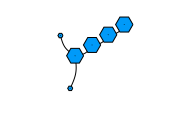

![](/assets/images/16902361047499149513.svg)

(Eisenia.KmerGraph{BioSequences.Mer{BioSequences.DNAAlphabet{2},7}}({6, 5} undirected simple Int64 graph, Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Array{Eisenia.EdgeEvidence,1}}(Edge 3 => 6 => [Eisenia.EdgeEvidence(68, 1)],Edge 2 => 4 => [Eisenia.EdgeEvidence(1, 2), Eisenia.EdgeEvidence(2, 2), Eisenia.EdgeEvidence(3, 2), Eisenia.EdgeEvidence(4, 2), Eisenia.EdgeEvidence(5, 2), Eisenia.EdgeEvidence(6, 2), Eisenia.EdgeEvidence(7, 2), Eisenia.EdgeEvidence(8, 1), Eisenia.EdgeEvidence(9, 2), Eisenia.EdgeEvidence(10, 2)  …  Eisenia.EdgeEvidence(90, 2), Eisenia.EdgeEvidence(91, 2), Eisenia.EdgeEvidence(92, 2), Eisenia.EdgeEvidence(93, 2), Eisenia.EdgeEvidence(94, 2), Eisenia.EdgeEvidence(95, 2), Eisenia.EdgeEvidence(96, 2), Eisenia.EdgeEvidence(97, 2), Eisenia.EdgeEvidence(99, 2), Eisenia.EdgeEvidence(100, 2)],Edge 1 => 4 => [Eisenia.EdgeEvidence(1, 1), Eisenia.EdgeEvidence(2, 3), Eisenia.EdgeEvidence(3, 1), Eisenia.EdgeEvidence(4, 1), Eisenia.EdgeEvidence(5, 1), Eisenia.EdgeEvidence(6,

In [13]:
graph, corrected_observations = iterate_until_convergence(Primes.primes(3, 7), observations, error_rate)

In [19]:
# PULL CODE FROM LOCAL LAPTOP TO FIX THIS!!
pruned_graph = clip_low_coverage_tips(graph, corrected_observations)

LoadError: MethodError: no method matching Eisenia.KmerGraph(::Type{BioSequences.Mer{BioSequences.DNAAlphabet{2},7}}, ::Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}, ::Array{BioSequences.Mer{BioSequences.DNAAlphabet{2},7},1}, ::Array{Int64,1})
Closest candidates are:
  Eisenia.KmerGraph(::Type{KMER_TYPE}, ::Any) where {A, K, KMER_TYPE<:BioSequences.AbstractMer{A,K}} at /home/jupyter-cjprybol/.julia/dev/Eisenia/src/Eisenia.jl:192

In [ ]:
take_a_walk(new_graph, connected_component)